# News Topic Classifier using Machine Learning


## Background
- Nowadays, people change their behaviour to get the information from Newspaper and Television to Online news Portal So there are so many News Portal out there, to become stand out and the best one, News Portal not only have to give a Actual and Factual News but also give a Good User Experience too.

## Goals
- In order to imcrease and improve a Good User Experience, we will try make a Machine Learning Modelling that Can give related articles based on Topics that User use in Search-bar  
- So when user search a topic, we will give them not only News that have same article-tags but also based on the content itself

===============================================================================================================

## Import Necessary Package

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting graphs
import sklearn # Machine Learning
%matplotlib inline

## Import the Data

In [2]:
df = pd.read_csv('news.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## Check the Data 
- to make sure there isnt any abnomaly data such as Missing Value

In [7]:
df.rename({'Text' : 'article_content', 'Category' : 'article_topic'},axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ArticleId        1490 non-null   int64 
 1   article_content  1490 non-null   object
 2   article_topic    1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


### There are Missing Value in article_content, so we will delete it because its in Content area.

In [9]:
df.isna().sum()

ArticleId          0
article_content    0
article_topic      0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.describe(include='O')

,article_content,article_topic
count,1490,1490
unique,1440,5
top,spam e-mails tempt net shoppers computer users...,sport
freq,2,346


### Associate article_topic names with numerical index and save it in new column topic_id, and View first 10 entries of topic_id, as a sanity check

In [12]:
df['topic_id'] = df['article_topic'].factorize()[0]
df['topic_id'][0:10]

0    0
1    0
2    0
3    1
4    0
5    2
6    3
7    4
8    0
9    4
Name: topic_id, dtype: int64

### Create a new pandas dataframe "topic_id_df", which only has unique article topic, also sorting this list in order of topic_id values

In [13]:
topic_id_df = df[['article_topic', 'topic_id']].drop_duplicates().sort_values('topic_id')

In [14]:
topic_id_df.head()

,article_topic,topic_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4



### Create a dictionary that can easily convert article topic names into topic_ids and vice-versa

In [15]:
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'article_topic']].values)

In [16]:
# Pick 5 random samples from the dataframe
df.sample(5, random_state=0)

,ArticleId,article_content,article_topic,topic_id
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4
354,1349,tory candidate quits over remark a conservativ...,politics,2
1227,1572,bath faced with tindall ultimatum mike tindall...,sport,3
907,1155,chancellor rallies labour voters gordon brown ...,politics,2
575,307,young debut cut short by ginepri fifteen-year-...,sport,3


### Group the dataframe by article topic and count items ( number of news articles) in each topic

In [17]:
df.groupby('article_topic').topic_id.count()

article_topic
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: topic_id, dtype: int64

### Visualize the distribution of article content by article Topic, we can see in here the topic is Imbalance, it will affect our Model, but we will ignore it this time

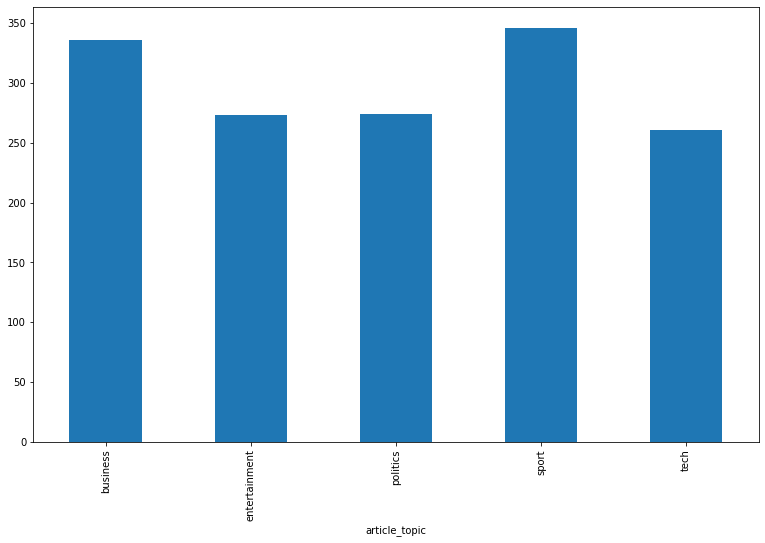

In [18]:
plt.figure(figsize=(13,8))
df.groupby('article_topic').topic_id.count().plot.bar(ylim=0);

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### We Will Clean the Data, we will throw away some stop words, punctuation and some no meaning words

In [20]:
from nltk.tokenize import word_tokenize
from nltk.corpus import  stopwords
from string import punctuation
import re
plus = ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama',
        'tidaknya', 'sumber', 'gambar', 'http', 'https', 'comsumber', 'wikipedia', 'com', 'wa', 
       'aka', 'ta', 'v2', 'dpmptsp', 'dok', 'qn', 'qnc', 'bu', 'yun', 'pin']
sw_indo = stopwords.words("indonesian") + list(punctuation) + plus

In [21]:
df['text-cleaned']=df.article_content.apply(lambda x: re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "",x))


### Convert words in the articles content into numerical features using tfdif (Term Frequency - Inverse Document Frequency)

`sklearn.feature_extraction.text.TfidfVectorizer` will be used to calculate a tf-idf vector for each of our documents. Note that we are passing a number of parameters to this class:

  - sublinear_df is set to True to use a logarithmic form for frequency, to give diminishing returns as the frequency of a word increases. This is usually preferable for a number of reasons, one of which being Zipf's Law.
  - min_df is the minimum numbers of documents a word must be present in to be kept, and we are setting it to 5. This is to avoid rare words, which drastically increase the size of our features and might cause overfitting.
  - norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1. This is helpful for visualizing these vectors, and can also improve (or deteriorate) the performance of some models.
  - encoding is set to latin-1 which is used by our input text.
  - ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams, or in other terms: we want to consider single words ("prices", "player") and pairs of words ("stock prices", "football player").
  - stop_words is set to **sw_indo** to remove all common pronouns and punctuation to further reduce the number of noisy features.



In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=sw_indo)

features = tfidf.fit_transform(df['text-cleaned']).toarray() 

labels = df.topic_id    

### Get a feel of the features identified by tfidf, we can see there are so many features in there, so it will take so much time for training

In [23]:
features.shape  

(1490, 21779)

### Recalling the dictionary created to map topic names to a number 

In [24]:
topic_to_id.items()

dict_items([('business', 0), ('tech', 1), ('politics', 2), ('sport', 3), ('entertainment', 4)])

### The sorted function Converts dictionary items into a (sorted) list. 
- In subsequent steps - We will use this list to iterate over the topics

In [25]:
sorted(topic_to_id.items())

[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

### We Use chi-square analysis to find corelation between features (importantce of words) and labels(article topics)
- We are going to look for top 3 grams for each-topics

In [26]:

from sklearn.feature_selection import chi2

N = 3  

#For each topics, find words that are highly corelated to it
for Topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)                   # Do chi2 analyses of all items in this topics
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(Topic))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . shares in
       . the firm
       . the company
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . box office
       . for best
       . the film
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . the party
       . the tories
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . the ball
       . the match
       . six nations
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . mobile phone
       . the net
       . the web


In [27]:
features_chi2

(array([0.08297401, 0.01421741, 0.00130908, ..., 0.00659937, 0.11238762,
        0.08708395]),
 array([0.77330687, 0.90508776, 0.97113782, ..., 0.93525386, 0.73744207,
        0.76791756]))


### We Use t-SNE : A Dimensionality reduction technique to visualize ( in 2 diemnsions), a high dimensional space
- t-Distributed Stochastic neighbor Embedding : Keeps similar instances close and dissimilar instances apart


In [28]:


from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally exhaustive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 


In [29]:
type(projected_features)

numpy.ndarray

In [30]:
projected_features[0]

array([11.674868, 26.235584], dtype=float32)

### t-SNE is used for Visualization, but in here we wont use it because of time limit constraints

## Model Training and Evaluation
We will try 2 different classification models on the data (Because of time limit):
- Logistic Regression
- MultinomialNB ( Naive Bayes)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    MultinomialNB(),
    LogisticRegression(random_state=42, max_iter = 500),
]

### Create a data frame that will store the results of various models.
- Each model will be run 4 times with different test sets of 25%


In [32]:
CV = 4  # Cross Validate with 4 different folds of 25% data ( 75-25 split with 4 folds )

#Create a data frame that will store the results for all 4 trials of the 2 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [33]:
## To Ignore the Warnings Notification (if any)
import warnings
warnings.filterwarnings('ignore')

### Run each Algorithm 4 times and store accuracy results in "entries"

In [34]:


#For each Algorithm 
for model in models:
    model_name = model.__class__.__name__
    # create 4 models with different 25% test sets, and store their accuracies
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    # Append all 4 accuracies into the entries list ( after all 2 models are run, there will be 3x4 = 12 entries)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))



### Store results in the results dataframe

In [35]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

### Use seaborn to visualize the results

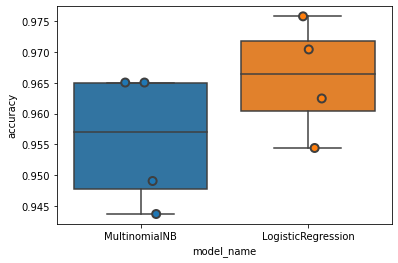

In [36]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2);

### Mean accuracy of each algorithm

In [37]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.965782
MultinomialNB         0.955717
Name: accuracy, dtype: float64

In [38]:
cv_df

,model_name,fold_idx,accuracy
0,MultinomialNB,0,0.943700
1,MultinomialNB,1,0.949062
2,MultinomialNB,2,0.965054
3,MultinomialNB,3,0.965054
4,LogisticRegression,0,0.954424
5,LogisticRegression,1,0.962466
6,LogisticRegression,2,0.970430
7,LogisticRegression,3,0.975806


### From those Dataframe, we will choose Logistic Regression as our Model (Because its better than MultinomialNB), then we will Model fit Logistic regression with 25% of data randomly chosen for test

In [39]:
from sklearn.model_selection import train_test_split


#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, stratify = labels, test_size=0.25, random_state=42)

### Logistic Regression
- Logistic Regression is one of the most simple and commonly used Machine Learning algorithms and commonly use for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem. Its basic fundamental concepts are also constructive in deep learning. Logistic regression describes and estimates the relationship between one dependent binary variable and independent variables. Eventhough commonly its used for Binary but, its can be applied for Multiclass Classification too.
- The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes.  It computes the probability of an event occurrence.
- It is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.
- I choose Logistic Regression because so far it is the fastest method that i have tried to solve this problem.

In [40]:
modelLR = LogisticRegression(random_state=0, max_iter = 400)
#Train Algorithm
modelLR.fit(X_train, y_train)

LogisticRegression(max_iter=400, random_state=0)

In [41]:
modelLR.score(X_test, y_test)

0.9624664879356568

## Finally - Use all the data to train the model

In [42]:
modelLR.fit(features, labels)

LogisticRegression(max_iter=400, random_state=0)

## Saving Model

In [43]:
import pickle

In [44]:
with open ('ModelLR.pkl', 'wb') as ML:
    pickle.dump(modelLR, ML)

## Evaluation Metrics

In [45]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [46]:
y_hat = modelLR.predict(features)

In [47]:
accuracy_score(labels, y_hat)

0.9973154362416108

In [48]:
f1_score(labels, y_hat, average='micro')

0.9973154362416108

In [49]:
print(classification_report(labels, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       336
           1       0.99      1.00      0.99       261
           2       1.00      1.00      1.00       274
           3       1.00      1.00      1.00       346
           4       1.00      1.00      1.00       273

    accuracy                           1.00      1490
   macro avg       1.00      1.00      1.00      1490
weighted avg       1.00      1.00      1.00      1490



### Predicting Sample Article (Article sample from Dataset)

## Sample 1

In [58]:
example = ["""worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (Â£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebber s lawyers have said he was unaware of the fraud  arguing that auditors did not alert him to any problems.  ms cooper also said that during shareholder meetings mr ebbers often passed over technical questions to the company s finance chief  giving only  brief  answers himself. the prosecution s star witness  former worldcom financial chief scott sullivan  has said that mr ebbers ordered accounting adjustments at the firm  telling him to  hit our books . however  ms cooper said mr sullivan had not mentioned  anything uncomfortable  about worldcom s accounting during a 2001 audit committee meeting. mr ebbers could face a jail sentence of 85 years if convicted of all the charges he is facing. worldcom emerged from bankruptcy protection in 2004  and is now known as mci. last week  mci agreed to a buyout by verizon communications in a deal valued at $6.75bn.
"""]

In [59]:
pred = tfidf.transform(example).toarray()

In [60]:
result = topic_id_df[df["topic_id"] == modelLR.predict(pred)[0]].iloc[0]['article_topic']
result

'business'

## Sample 2

In [61]:
example2 = ["""" lifestyle  governs mobile choice  faster  better or funkier hardware alone is not going to help phone firms sell more handsets  research suggests.  instead  phone firms keen to get more out of their customers should not just be pushing the technology for its own sake. consumers are far more interested in how handsets fit in with their lifestyle than they are in screen size  onboard memory or the chip inside  shows an in-depth study by handset maker ericsson.  historically in the industry there has been too much focus on using technology   said dr michael bjorn  senior advisor on mobile media at ericsson s consumer and enterprise lab.  we have to stop saying that these technologies will change their lives   he said.  we should try to speak to consumers in their own language and help them see how it fits in with what they are doing   he told the bbc news website.  for the study  ericsson interviewed 14 000 mobile phone owners on the ways they use their phone.  people s habits remain the same   said dr bjorn.  they just move the activity into the mobile phone as it s a much more convenient way to do it.   one good example of this was diary-writing among younger people  he said. while diaries have always been popular  a mobile phone -- especially one equipped with a camera -- helps them keep it in a different form. youngsters  use of text messages also reflects their desire to chat and keep in contact with friends and again just lets them do it in a slightly changed way. dr bjorn said that although consumers do what they always did but use a phone to do it  the sheer variety of what the new handset technologies make possible does gradually drive new habits and lifestyles. ericsson s research has shown that consumers divide into different  tribes  that use phones in different ways. dr bjorn said groups dubbed  pioneers  and  materialists  were most interested in trying new things and were behind the start of many trends in phone use.  for instance   he said   older people are using sms much more than they did five years ago.  this was because younger users  often the children of ageing mobile owners  encouraged older people to try it so they could keep in touch.  another factor governing the speed of change in mobile phone use was the simple speed with which new devices are bought by pioneers and materialists. only when about 25% of people have handsets with new innovations on them  such as cameras  can consumers stop worrying that if they send a picture message the person at the other end will be able to see it.  once this significant number of users is passed  use of new innovations tends to take off. dr bjorn said that early reports of camera phone usage in japan seemed to imply that the innovation was going to be a flop. however  he said  now 45% of the japanese people ericsson questioned use their camera phone at least once a month. in 2003 the figure was 29%. similarly  across europe the numbers of people taking snaps with cameras is starting to rise. in 2003 only 4% of the people in the uk took a phonecam snap at least once a month. now the figure is 14%. similar rises have been seen in many other european nations. dr bjorn said that people also used their camera phones in very different ways to film and even digital cameras.  usage patterns for digital cameras are almost exactly replacing usage patterns for analogue cameras   he said. digital cameras tend to be used on significant events such as weddings  holidays and birthdays. by contrast  he said  camera phones were being used much more to capture a moment and were being woven into everyday life.
"
"""]

In [62]:
pred2 = tfidf.transform(example2).toarray()

In [63]:
result2 = topic_id_df[df["topic_id"] == modelLR.predict(pred2)[0]].iloc[0]['article_topic']
result2

'tech'

## Improvement in the Future

###  i will try something to Improve the Accuracy of The Model & Reduce the Training time
   - I have already try Train the Model using `BERT and TensorFlow` but it took so much time, its **time consuming**, if there are more time, i'll try to Tuning the Model so it will be faster
   - I will try words Embedding such as `GLOVE, Word2Vec, FastText` and combine it with `Tensorflow`
   - Try to train the Model using `Words Embedding` or `BERT` with `PyTorch`
   - I have already try to train the Model using `RandomForest` and `XGBoost` but, the problem is same it took so much time, i'll try to tuning them Next time
   - I try to `Balancing the Topics` (Because of Imbalance problem) the Model will have difficulty to predict the topics that have few data (content)
   - Use `Hyper Parameter Tuning` for the Model